# Generative Adversarial Networks
- https://skymind.ai/wiki/generative-adversarial-network-gan
- https://towardsdatascience.com/understanding-generative-adversarial-networks-gans-cd6e4651a29
- https://papers.nips.cc/paper/5423-generative-adversarial-nets.pdf
- https://machinelearningmastery.com/what-are-generative-adversarial-networks-gans/
- https://arxiv.org/pdf/1511.06434.pdf

In [1]:
import os
import scipy as sp
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from skimage import io
import time
from datetime import datetime
import requests
import zipfile
from glob import glob
from tqdm import tqdm

In [2]:
def lrelu(x, alpha=.2):
    return tf.maximum(alpha*x, x)

In [3]:
class ConvLayer(object):
    def __init__(self, name, sz_in, sz_out, apply_batch_norm=True, sz_filter=5, stride=2, activation=tf.nn.relu):
        """
            Descr: initializes a convolution layer
            
            Params:
                name:
                sz_in:
                sz_out:
                apply_batch_norm:
                sz_filter:
                stride:
                activation:
        """
        self.W = tf.get_variable("W_%s" % name, shape=(sz_filter, sz_filter, sz_in, sz_out), initializer=tf.truncated_normal_initializer(stddev=.02))
        self.b = tf.get_variable("b_%s" % name, shape=(sz_out,), initializer=tf.zeros_initializer())
        
        self.name = name
        self.activation = activation
        self.stride = stride
        self.apply_batch_norm = apply_batch_norm
        self.params = [self.W, self.b]
        
    def forward(self, X, reuse, is_training, decay=.9, epsilon=1e-5):
        """
            Descr: performs feedforward operation on a layer
            
            Params:
                X:
                reuse:
                is_training:
                decay:
                epsilon:
        """
        conv_out = tf.nn.conv2d(X, self.W, strides=[1, self.stride, self.stride, 1], padding='SAME')
        conv_out = tf.nn.bias_add(conv_out, self.b)
        
        if(self.apply_batch_norm):
            conv_out = tf.contrib.layers.batch_norm(conv_out, decay=decay, updates_collections=None, epsilon=epsilon, scale=True, is_training=is_training, reuse=reuse, scope=self.name)
        
        return self.activation(conv_out)
    
class FractionallyStridedConvLayer(object):
    def __init__(self, name, sz_in, sz_out, output_shape, apply_batch_norm=True, sz_filter=5, stride=2, activation=tf.nn.relu):
        """
            Descr: initializes a fractionally strided convolution layer (i.e. deconvolution)
            
            Params:
                name:
                sz_in:
                sz_out:
                output_shape:
                apply_batch_norm:
                sz_filter:
                stride:
                activation:
        """
        self.W = tf.get_variable("W_%s" % name, shape=(sz_filter, sz_filter, sz_out, sz_in), initializer=tf.random_normal_initializer(stddev=.02))
        self.b = tf.get_variable("b_%s" % name, shape=(sz_out,), initializer=tf.zeros_initializer())
        
        self.name = name
        self.activation = activation
        self.stride = stride
        self.apply_batch_norm = apply_batch_norm
        self.output_shape = output_shape
        self.params = [self.W, self.b]
        
    def forward(self, X, reuse, is_training, decay=.9, epsilon=1e-5):
        """
            Descr: performs feedforward operation on a layer
            
            Params:
                X:
                reuse:
                is_training:
                decay:
                epsilon:
        """
        conv_out = tf.nn.conv2d_transpose(value=X, filter=self.W, output_shape=self.output_shape, strides=[1, self.stride, self.stride, 1])
        conv_out = tf.nn.bias_add(conv_out, self.b)
        
        if(self.apply_batch_norm):
            conv_out = tf.contrib.layers.batch_norm(conv_out, decay=decay, updates_collections=None, epsilon=epsilon, scale=True, is_training=is_training, reuse=reuse, scope=self.name)
        
        return self.activation(conv_out)
        
class DenseLayer(object):
    def __init__(self, name, sz_in, sz_out, apply_batch_norm=True, activation=tf.nn.relu):
        """
            Descr: initializes a fully connected layer
            
            Params:
                name:
                sz_in:
                sz_out:
                apply_batch_norm:
                activation:
        """
        self.W = tf.get_variable("W_%s" % name, shape=(sz_in, sz_out), initializer=tf.random_normal_initializer(stddev=.02))
        self.b = tf.get_variable("b_%s" % name, shape=(sz_out, ), initializer=tf.zeros_initializer())
        
        self.activation = activation
        self.name = name
        self.apply_batch_norm = apply_batch_norm
        self.params = [self.W, self.b]
        
    def forward(self, X, reuse, is_training, decay=.9, epsilon=1e-5):
        """
            Descr: performs feedforward operation on a layer
            
            Params:
                X:
                reuse:
                is_training:
                decay:
                epsilon:
        """
        layer_out = tf.matmul(X, self.W) + self.b
        
        if(self.apply_batch_norm):
            layer_out = tf.contrib.layers.batch_norm(layer_out, decay=decay, updates_collections=None, epsilon=epsilon, scale=True, is_training=is_training, reuse=reuse, scope=self.name)
        
        return self.activation(layer_out)     
    
class DCGAN(object):
    def __init__(self, img_length, num_colors, d_sizes, g_sizes):
        """
            Descr: initializes a DCGAN network
            
            Params:
                img_length:
                num_colors:
                d_sizes:
                g_sizes:
        """
        # save for later
        self.img_length = img_length
        self.num_colors = num_colors
        self.latent_dims = g_sizes['z']

        # define the input data
        self.X = tf.placeholder(
          tf.float32,
          shape=(None, img_length, img_length, num_colors),
          name='X'
        )
        self.Z = tf.placeholder(
          tf.float32,
          shape=(None, self.latent_dims),
          name='Z'
        )

        # note: by making batch_sz a placeholder, we can specify a variable
        # number of samples in the FS-conv operation where we are required
        # to pass in output_shape
        # we need only pass in the batch size via feed_dict
        self.batch_sz = tf.placeholder(tf.int32, shape=(), name='batch_sz')

        # build the discriminator
        logits = self.build_discriminator(self.X, d_sizes)

        # build generator
        self.sample_images = self.build_generator(self.Z, g_sizes)

        # get sample logits
        with tf.variable_scope("discriminator") as scope:
            scope.reuse_variables()
            sample_logits = self.d_forward(self.sample_images, True)

        # get sample images for test time (batch norm is different)
        with tf.variable_scope("generator") as scope:
            scope.reuse_variables()
            self.sample_images_test = self.g_forward(
            self.Z, reuse=True, is_training=False
            )

        # build costs
        self.d_cost_real = tf.nn.sigmoid_cross_entropy_with_logits(
          logits=logits,
          labels=tf.ones_like(logits)
        )
        self.d_cost_fake = tf.nn.sigmoid_cross_entropy_with_logits(
          logits=sample_logits,
          labels=tf.zeros_like(sample_logits)
        )
        self.d_cost = tf.reduce_mean(self.d_cost_real) + tf.reduce_mean(self.d_cost_fake)
        self.g_cost = tf.reduce_mean(
          tf.nn.sigmoid_cross_entropy_with_logits(
            logits=sample_logits,
            labels=tf.ones_like(sample_logits)
          )
        )
        real_predictions = tf.cast(logits > 0, tf.float32)
        fake_predictions = tf.cast(sample_logits < 0, tf.float32)
        num_predictions = 2.0*BATCH_SIZE
        num_correct = tf.reduce_sum(real_predictions) + tf.reduce_sum(fake_predictions)
        self.d_accuracy = num_correct / num_predictions


        # optimizers
        self.d_params = [t for t in tf.trainable_variables() if t.name.startswith('d')]
        self.g_params = [t for t in tf.trainable_variables() if t.name.startswith('g')]

        self.d_train_op = tf.train.AdamOptimizer(
          LEARNING_RATE, beta1=BETA1
        ).minimize(
          self.d_cost, var_list=self.d_params
        )
        self.g_train_op = tf.train.AdamOptimizer(
          LEARNING_RATE, beta1=BETA1
        ).minimize(
          self.g_cost, var_list=self.g_params
        )

        # show_all_variables()
        # exit()

        # set up session and variables for later
        self.init_op = tf.global_variables_initializer()
        self.sess = tf.InteractiveSession()
        self.sess.run(self.init_op)


    def build_discriminator(self, X, d_sizes):
        with tf.variable_scope("discriminator") as scope:

            # build conv layers
            self.d_convlayers = []
            mi = self.num_colors
            dim = self.img_length
            count = 0
            for mo, filtersz, stride, apply_batch_norm in d_sizes['conv_layers']:
                # make up a name - used for get_variable
                name = "convlayer_%s" % count
                count += 1

                layer = ConvLayer(name, mi, mo, apply_batch_norm, filtersz, stride, lrelu)
                self.d_convlayers.append(layer)
                mi = mo
                print("dim:", dim)
                dim = int(np.ceil(float(dim) / stride))


            mi = mi * dim * dim
            # build dense layers
            self.d_denselayers = []
            for mo, apply_batch_norm in d_sizes['dense_layers']:
                name = "denselayer_%s" % count
                count += 1

                layer = DenseLayer(name, mi, mo, apply_batch_norm, lrelu)
                mi = mo
                self.d_denselayers.append(layer)


            # final logistic layer
            name = "denselayer_%s" % count
            self.d_finallayer = DenseLayer(name, mi, 1, False, lambda x: x)

            # get the logits
            logits = self.d_forward(X)

            # build the cost later
            return logits


    def d_forward(self, X, reuse=None, is_training=True):
        # encapsulate this because we use it twice
        output = X
        for layer in self.d_convlayers:
            output = layer.forward(output, reuse, is_training)
        output = tf.contrib.layers.flatten(output)
        for layer in self.d_denselayers:
            output = layer.forward(output, reuse, is_training)
        logits = self.d_finallayer.forward(output, reuse, is_training)
        return logits


    def build_generator(self, Z, g_sizes):
        with tf.variable_scope("generator") as scope:

            # determine the size of the data at each step
            dims = [self.img_length]
            dim = self.img_length
            for _, _, stride, _ in reversed(g_sizes['conv_layers']):
                dim = int(np.ceil(float(dim) / stride))
                dims.append(dim)

            # note: dims is actually backwards
            # the first layer of the generator is actually last
            # so let's reverse it
            dims = list(reversed(dims))
            print("dims:", dims)
            self.g_dims = dims


            # dense layers
            mi = self.latent_dims
            self.g_denselayers = []
            count = 0
            for mo, apply_batch_norm in g_sizes['dense_layers']:
                name = "g_denselayer_%s" % count
                count += 1

                layer = DenseLayer(name, mi, mo, apply_batch_norm)
                self.g_denselayers.append(layer)
                mi = mo

            # final dense layer
            mo = g_sizes['projection'] * dims[0] * dims[0]
            name = "g_denselayer_%s" % count
            layer = DenseLayer(name, mi, mo, not g_sizes['bn_after_project'])
            self.g_denselayers.append(layer)


            # fs-conv layers
            mi = g_sizes['projection']
            self.g_convlayers = []

            # output may use tanh or sigmoid
            num_relus = len(g_sizes['conv_layers']) - 1
            activation_functions = [tf.nn.relu]*num_relus + [g_sizes['output_activation']]

            for i in range(len(g_sizes['conv_layers'])):
                name = "fs_convlayer_%s" % i
                mo, filtersz, stride, apply_batch_norm = g_sizes['conv_layers'][i]
                f = activation_functions[i]
                output_shape = [self.batch_sz, dims[i+1], dims[i+1], mo]
                print("mi:", mi, "mo:", mo, "outp shape:", output_shape)
                layer = FractionallyStridedConvLayer(
                  name, mi, mo, output_shape, apply_batch_norm, filtersz, stride, f
                )
                self.g_convlayers.append(layer)
                mi = mo

            # get the output
            self.g_sizes = g_sizes
            return self.g_forward(Z)


    def g_forward(self, Z, reuse=None, is_training=True):
        # dense layers
        output = Z
        for layer in self.g_denselayers:
            output = layer.forward(output, reuse, is_training)

        # project and reshape
        output = tf.reshape(
        output,
        [-1, self.g_dims[0], self.g_dims[0], self.g_sizes['projection']],
        )

        # apply batch norm
        if self.g_sizes['bn_after_project']:
            output = tf.contrib.layers.batch_norm(
            output,
            decay=0.9, 
            updates_collections=None,
            epsilon=1e-5,
            scale=True,
            is_training=is_training,
            reuse=reuse,
            scope='bn_after_project'
            )

        # pass through fs-conv layers
        for layer in self.g_convlayers:
            output = layer.forward(output, reuse, is_training)

        return output


    def fit(self, X):
        d_costs = []
        g_costs = []

        N = len(X)
        n_batches = N // BATCH_SIZE
        total_iters = 0
        for i in range(EPOCHS):
            print("epoch:", i)
            np.random.shuffle(X)
            for j in range(n_batches):
                t0 = datetime.now()

                if type(X[0]) is str:
                    # is celeb dataset
                    batch = files2images(
                    X[j*BATCH_SIZE:(j+1)*BATCH_SIZE]
                    )

                else:
                    # is mnist dataset
                    batch = X[j*BATCH_SIZE:(j+1)*BATCH_SIZE]

                Z = np.random.uniform(-1, 1, size=(BATCH_SIZE, self.latent_dims))

                # train the discriminator
                _, d_cost, d_acc = self.sess.run(
                (self.d_train_op, self.d_cost, self.d_accuracy),
                feed_dict={self.X: batch, self.Z: Z, self.batch_sz: BATCH_SIZE},
                )
                d_costs.append(d_cost)

                # train the generator
                _, g_cost1 = self.sess.run(
                (self.g_train_op, self.g_cost),
                feed_dict={self.Z: Z, self.batch_sz: BATCH_SIZE},
                )
                # g_costs.append(g_cost1)
                _, g_cost2 = self.sess.run(
                (self.g_train_op, self.g_cost),
                feed_dict={self.Z: Z, self.batch_sz: BATCH_SIZE},
                )
                g_costs.append((g_cost1 + g_cost2)/2) # just use the avg


                # save samples periodically
                total_iters += 1
                if total_iters % SAVE_SAMPLE_PERIOD == 0:
                    print("  batch: %d/%d  -  dt: %s - d_acc: %.2f" % (j+1, n_batches, datetime.now() - t0, d_acc))
                    samples = self.sample(64) # shape is (64, D, D, color)

                    # for convenience
                    d = self.img_length

                    if samples.shape[-1] == 1:
                        # if color == 1, we want a 2-D image (N x N)
                        samples = samples.reshape(64, d, d)
                        flat_image = np.empty((8*d, 8*d))

                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k].reshape(d, d)
                                k += 1

                        # plt.imshow(flat_image, cmap='gray')
                    else:
                        # if color == 3, we want a 3-D image (N x N x 3)
                        flat_image = np.empty((8*d, 8*d, 3))
                        k = 0
                        for i in range(8):
                            for j in range(8):
                                flat_image[i*d:(i+1)*d, j*d:(j+1)*d] = samples[k]
                                k += 1
                        # plt.imshow(flat_image)

                    # plt.savefig('samples/samples_at_iter_%d.png' % total_iters)
                    io.imsave(
                    'samples/samples_at_iter_%d.png' % total_iters,
                    flat_image,
                    )

        # save a plot of the costs
        return d_costs, g_costs

    def sample(self, n):
        Z = np.random.uniform(-1, 1, size=(n, self.latent_dims))
        samples = self.sess.run(self.sample_images_test, feed_dict={self.Z: Z, self.batch_sz: n})
        return samples
      

In [4]:
def get_mnist(limit=None):
    df = pd.read_csv('datasets/mnist_train_kaggle.csv')
    data = df.values
    # np.random.shuffle(data)
    X = data[:, 1:] / 255.0 # data is from 0..255
    Y = data[:, 0]
    X, Y = shuffle(X, Y)
    if limit is not None:
        X, Y = X[:limit], Y[:limit]
    return X, Y

def get_celeb(limit=None):
    if not os.path.exists('../large_files'):
        os.mkdir('../large_files')

    # eventual place where our final data will reside
    if not os.path.exists('../large_files/img_align_celeba-cropped'):

        # check for original data
        if not os.path.exists('../large_files/img_align_celeba'):
            # download the file and place it here
            if not os.path.exists('../large_files/img_align_celeba.zip'):
                print("Downloading img_align_celeba.zip...")
                download_file(
                '0B7EVK8r0v71pZjFTYXZWM3FlRnM',
                '../large_files/img_align_celeba.zip'
                )

            # unzip the file
            print("Extracting img_align_celeba.zip...")
            with zipfile.ZipFile('../large_files/img_align_celeba.zip') as zf:
                zip_dir = zf.namelist()[0]
                zf.extractall('../large_files')


        # load in the original images
        filenames = glob("../large_files/img_align_celeba/*.jpg")
        N = len(filenames)
        print("Found %d files!" % N)


        # crop the images to 64x64
        #os.mkdir('../large_files/img_align_celeba-cropped')
        print("Cropping images, please wait...")

        for i in range(N):
            crop_and_resave(filenames[i], '../large_files/img_align_celeba-cropped')
            if i % 1000 == 0:
                print("%d/%d" % (i, N))


    # make sure to return the cropped version
    filenames = glob("../large_files/img_align_celeba-cropped/img_align_celeba/*.jpg")
    return filenames


def crop_and_resave(inputfile, outputdir):
    from PIL import Image
    # theoretically, we could try to find the face
    # but let's be lazy
    # we assume that the middle 108 pixels will contain the face
    im = Image.open(inputfile)
    small = im.resize((64, 64), Image.ANTIALIAS)

    filename = inputfile.split('/')[-1]
    small.save("%s/%s" % (outputdir, filename))


def files2images(filenames):
    return [scale_image(plt.imread(fn)) for fn in filenames]

    
def scale_image(im):
    # scale to (-1, +1)
    return (im / 255.0)*2 - 1

def download_file(file_id, dest):
    drive_url = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(drive_url, params={'id': file_id}, stream=True)
    token = get_confirm_token(response)

    if token:
        params = {'id': file_id, 'confirm': token}
        response = session.get(drive_url, params=params, stream=True)

    save_response_content(response, dest)

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None

def save_response_content(r, dest):
    # unfortunately content-length is not provided in header
    total_iters = 1409659 # in KB
    #print("Note: units are in KB, e.g. KKB = MB")
    # because we are reading 1024 bytes at a time, hence
    # 1KB == 1 "unit" for tqdm
    with open(dest, 'wb') as f:
        for chunk in tqdm(
            r.iter_content(1024),
            total=total_iters,
            unit='KB',
            unit_scale=True):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)
                

In [5]:
# some constants
LEARNING_RATE = 0.0002
BETA1 = 0.5
BATCH_SIZE = 128
EPOCHS = 2
SAVE_SAMPLE_PERIOD = 100

X = get_celeb()
# just loads a list of filenames, we will load them in dynamically
# because there are many
dim = 64
colors = 3

# for celeb
d_sizes = {
'conv_layers': [
  (64, 5, 2, False),
  (128, 5, 2, True),
  (256, 5, 2, True),
  (512, 5, 2, True)
],
'dense_layers': [],
}
g_sizes = {
'z': 100,
'projection': 512,
'bn_after_project': True,
'conv_layers': [
  (256, 5, 2, True),
  (128, 5, 2, True),
  (64, 5, 2, True),
  (colors, 5, 2, False)
],
'dense_layers': [],
'output_activation': tf.tanh,
}

# setup gan
# note: assume square images, so only need 1 dim

dim: 64
dim: 32
dim: 16
dim: 8
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
dims: [4, 8, 16, 32, 64]
mi: 512 mo: 256 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 8, 8, 256]
mi: 256 mo: 128 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 16, 16, 128]
mi: 128 mo: 64 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 32, 32, 64]
mi: 64 mo: 3 outp shape: [<tf.Tensor 'batch_sz:0' shape=() dtype=int32>, 64, 64, 3]
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
epoch: 0
  batch: 100/1582  -  dt: 0:00:00.349079 - d_acc: 0.48


Lossy conversion from float64 to uint8. Range [-0.9925729632377625, 0.966920018196106]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 200/1582  -  dt: 0:00:00.349127 - d_acc: 0.72


Lossy conversion from float64 to uint8. Range [-0.9980903267860413, 0.9914723038673401]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 300/1582  -  dt: 0:00:00.361081 - d_acc: 0.68


Lossy conversion from float64 to uint8. Range [-0.9998900890350342, 0.999933123588562]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 400/1582  -  dt: 0:00:00.344148 - d_acc: 0.62


Lossy conversion from float64 to uint8. Range [-0.9999790787696838, 0.9999879002571106]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 500/1582  -  dt: 0:00:00.351080 - d_acc: 0.66


Lossy conversion from float64 to uint8. Range [-0.9999983906745911, 0.999993085861206]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 600/1582  -  dt: 0:00:00.345078 - d_acc: 0.67


Lossy conversion from float64 to uint8. Range [-0.9999953508377075, 0.9999980926513672]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 700/1582  -  dt: 0:00:00.352079 - d_acc: 0.71


Lossy conversion from float64 to uint8. Range [-0.9999999403953552, 0.9999951720237732]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 800/1582  -  dt: 0:00:00.347078 - d_acc: 0.64


Lossy conversion from float64 to uint8. Range [-0.9999992251396179, 0.9999999403953552]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 900/1582  -  dt: 0:00:00.346078 - d_acc: 0.53


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999940395355225]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1000/1582  -  dt: 0:00:00.344086 - d_acc: 0.71


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999828934669495]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1100/1582  -  dt: 0:00:00.348078 - d_acc: 0.76


Lossy conversion from float64 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1200/1582  -  dt: 0:00:00.356081 - d_acc: 0.78


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999993443489075]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1300/1582  -  dt: 0:00:00.347079 - d_acc: 0.64


Lossy conversion from float64 to uint8. Range [-0.9999999403953552, 0.9999053478240967]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1400/1582  -  dt: 0:00:00.346078 - d_acc: 0.51


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999989867210388]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1500/1582  -  dt: 0:00:00.349079 - d_acc: 0.68


Lossy conversion from float64 to uint8. Range [-1.0, 0.9998860955238342]. Convert image to uint8 prior to saving to suppress this warning.


epoch: 1
  batch: 18/1582  -  dt: 0:00:00.348078 - d_acc: 0.53


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999997019767761]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 118/1582  -  dt: 0:00:00.352080 - d_acc: 0.63


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999558925628662]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 218/1582  -  dt: 0:00:00.349079 - d_acc: 0.70


Lossy conversion from float64 to uint8. Range [-0.9999994039535522, 0.9999857544898987]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 318/1582  -  dt: 0:00:00.347078 - d_acc: 0.66


Lossy conversion from float64 to uint8. Range [-1.0, 0.99991774559021]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 418/1582  -  dt: 0:00:00.347079 - d_acc: 0.61


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999721050262451]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 518/1582  -  dt: 0:00:00.346078 - d_acc: 0.58


Lossy conversion from float64 to uint8. Range [-1.0, 0.9999443292617798]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 618/1582  -  dt: 0:00:00.348078 - d_acc: 0.54


Lossy conversion from float64 to uint8. Range [-1.0, 0.9997981786727905]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 718/1582  -  dt: 0:00:00.351207 - d_acc: 0.59


Lossy conversion from float64 to uint8. Range [-0.9999999403953552, 0.9999987483024597]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 818/1582  -  dt: 0:00:00.348079 - d_acc: 0.47


Lossy conversion from float64 to uint8. Range [-1.0, 0.999605655670166]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 918/1582  -  dt: 0:00:00.346078 - d_acc: 0.53


Lossy conversion from float64 to uint8. Range [-0.9999998807907104, 0.9999603033065796]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1018/1582  -  dt: 0:00:00.341078 - d_acc: 0.67


Lossy conversion from float64 to uint8. Range [-0.9999312162399292, 0.9999752044677734]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1118/1582  -  dt: 0:00:00.342078 - d_acc: 0.66


Lossy conversion from float64 to uint8. Range [-1.0, 0.9998552203178406]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1218/1582  -  dt: 0:00:00.342086 - d_acc: 0.68


Lossy conversion from float64 to uint8. Range [-0.9999995231628418, 0.9999440312385559]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1318/1582  -  dt: 0:00:00.348078 - d_acc: 0.54


Lossy conversion from float64 to uint8. Range [-0.9999998211860657, 0.9991361498832703]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1418/1582  -  dt: 0:00:00.354080 - d_acc: 0.61


Lossy conversion from float64 to uint8. Range [-0.9999842047691345, 0.9998964071273804]. Convert image to uint8 prior to saving to suppress this warning.


  batch: 1518/1582  -  dt: 0:00:00.346078 - d_acc: 0.56


Lossy conversion from float64 to uint8. Range [-0.9999972581863403, 0.9999383687973022]. Convert image to uint8 prior to saving to suppress this warning.


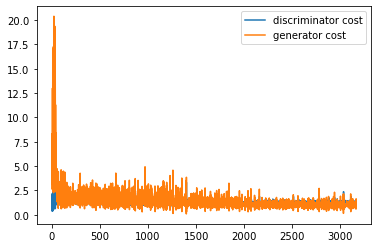

In [6]:
with tf.device('/gpu:0'):
    gan = DCGAN(dim, colors, d_sizes, g_sizes)
    d, g = gan.fit(X)

plt.clf()
plt.plot(d, label='discriminator cost')
plt.plot(g, label='generator cost')
plt.legend()
plt.savefig('cost_vs_iteration.png')

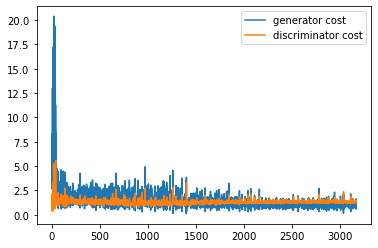

In [83]:
plt.plot(g, label='generator cost')
plt.plot(d, label='discriminator cost')
plt.legend()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


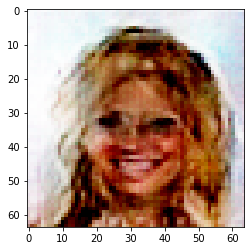

In [82]:
plt.imshow(gan.sample(1).reshape(64,64,3))